In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Earthquake\ Shelter\ Project

Mounted at /content/drive
/content/drive/MyDrive/Earthquake Shelter Project


In [3]:
!pip install spektral --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 1.4 MB/s eta 0:00:00


In [1]:
!pip install "pandas<2.0.0" --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 19.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 1.5.3 which is incompatible.


In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from scipy.sparse import csr_matrix

import xgboost as xgb

import tensorflow as tf
import spektral

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from spektral.layers import ECCConv, GlobalSumPool

from spektral.data import Dataset, Graph
from spektral.data.loaders import SingleLoader, DisjointLoader
from spektral.datasets.citation import Citation
from spektral.layers import GCNConv, ChebConv, GATConv, ARMAConv
from spektral.models.gcn import GCN
from spektral.models import GeneralGNN
from spektral.transforms import LayerPreprocess

In [6]:
def read_pickle(dataset_name):
  with open('data/' + dataset_name + '.pkl', 'rb') as file_:
    return pickle.load(file_)

In [7]:
feature_df = read_pickle('all_features')
feature_df[['prefecture', 'mesh_id', 'latitude', 'longitude', 'shelter_count']]

,prefecture,mesh_id,latitude,longitude,shelter_count
106,kanagawa,52386788,35.23333,138.9750,0
107,kanagawa,52386789,35.23333,138.9875,0
108,kanagawa,52386799,35.24167,138.9875,0
109,kanagawa,52387709,35.25000,138.9875,0
110,kanagawa,52387719,35.25833,138.9875,0
...,...,...,...,...,...
3104,ibaraki,54407590,36.65833,140.6250,0
3105,ibaraki,54407593,36.65833,140.6625,0
3106,ibaraki,54407594,36.65833,140.6750,0
3107,ibaraki,54407595,36.65833,140.6875,0


In [8]:
feature_df[feature_df['prefecture'] == 'ibaraki']

,mesh_id,latitude,longitude,area,rice_paddy,other_agriculture,forest,wasteland,building,road_transport,...,shelter_capacity,admin_code,2015,total,0-14,15-64,65+,75+,80+,prefecture
12136,53397709,35.91667,139.9875,1042302,0.23,0.200000,0.220000,0.08,0.250001,0.00,...,0,8224,719.1492,752.8405,90.9731,478.5614,183.3060,77.0239,42.7703,ibaraki
12143,53397718,35.92500,139.9750,1042199,0.12,0.339999,0.220000,0.17,0.140000,0.00,...,0,8224,325.8909,282.1211,27.6379,134.7043,119.7789,70.3333,49.2971,ibaraki
12144,53397719,35.92500,139.9875,1042194,0.24,0.000000,0.050000,0.00,0.549999,0.01,...,0,8224,1854.8554,1926.5981,247.9921,1167.9287,510.6772,267.0911,145.1158,ibaraki
12150,53397726,35.93333,139.9500,1042102,0.43,0.220000,0.030000,0.00,0.020000,0.00,...,0,8224,23.3183,22.2999,1.9456,11.3645,8.9898,3.1967,1.3869,ibaraki
12151,53397727,35.93333,139.9625,1042096,0.04,0.250000,0.100000,0.03,0.349999,0.15,...,0,8224,251.9675,254.7661,39.8516,139.5557,75.3587,47.3080,23.8700,ibaraki
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104,54407590,36.65833,140.6250,1032429,0.02,0.000000,0.789999,0.03,0.000000,0.00,...,0,8202,14.9881,10.3759,0.0000,3.6713,6.7046,3.9642,3.1207,ibaraki
3105,54407593,36.65833,140.6625,1032424,0.09,0.040000,0.720000,0.00,0.000000,0.03,...,0,8202,167.4681,153.1830,19.3547,92.7364,41.0918,21.5727,15.3604,ibaraki
3106,54407594,36.65833,140.6750,1032422,0.03,0.020000,0.400000,0.01,0.440000,0.00,...,0,8202,2550.0067,2377.7682,266.0463,1353.3193,758.4026,395.4842,219.4620,ibaraki
3107,54407595,36.65833,140.6875,1032420,0.17,0.000000,0.000000,0.00,0.740000,0.00,...,0,8202,2192.2175,1977.9305,211.9500,1128.7168,637.2637,352.3242,229.0642,ibaraki


```python
X_df = feature_df.drop(['mesh_id', 'latitude', 'longitude', 'area',
                     'admin_code', '2015', 'total', 'shelter_count'], axis=1)
X_cols = ['dist_to_water', '0-14', '15-64', '65+', '75+', '80+']
X_df[X_cols] = (X_df[X_cols] - X_df[X_cols].min()) / (X_df[X_cols].max() - X_df[X_cols].min())
X = X_df.values.astype(np.float32)
X.shape
```

```python
y = (feature_df['shelter_count'] > 0).values.astype(np.float32).reshape(-1, 1)
y.shape
```

In [9]:
X = np.load('data/arrays/tokyo_less/x.npy', allow_pickle=True).astype(np.float32)
a = np.load('data/arrays/tokyo_less/a.npy', allow_pickle=True).astype(np.float32)
y = np.load('data/arrays/tokyo_less/y.npy', allow_pickle=True).astype(np.float32)
X_df = read_pickle('arrays/tokyo_less/features_df')

In [13]:
y = 1 - y

In [14]:
X.shape, a.shape, y.shape

((964, 26), (964, 964), (964, 1))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(771, 26) (193, 26) (771, 1) (193, 1)


In [18]:
X_train[0][-5:]

array([ 1688.1342, 14320.925 ,  4163.3154,  2516.3887,  1547.5602],
      dtype=float32)

In [35]:
feature_df.loc[10199][-6:-1].values.flatten().astype(np.float32)

array([ 1688.1342, 14320.925 ,  4163.3154,  2516.3887,  1547.5602],
      dtype=float32)

In [36]:
np.array_equal(X_train[0][-5:], feature_df.loc[10199][-6:-1].values.flatten().astype(np.float32))

True

In [37]:
X_df.columns

Index(['index', 'admin_code', 'type_general', 'type_specific', 'name',
       'address', 'maintenance_code', 'latitude', 'longitude',
       'inside_tokyo_mainland', 'area', 'stories_above_ground',
       'stories_below_ground', 'road_width', 'nearest_station',
       'dist_to_station', 'steel_frame', 'reinforced_concrete', 'lightweight',
       'block', 'wood', 'shelter', 'rice_paddy', 'other_agriculture', 'forest',
       'wasteland', 'building', 'road_transport', 'rail_transport',
       'other_site', 'river_wetland', 'seashore', 'sea', 'golf_course',
       'unknown', 'dist_to_water', '0-14', '15-64', '65+', '75+', '80+'],
      dtype='object')

In [ ]:
def check_pred_similarity(y_test, preds, features_df):
  preds = 1 - preds # flipping labels done earlier

  test_mask = np.isin(X_df.index, y_test)
  test_counts = features_df[test_mask]['shelter_count'].values.flatten()
  assert len(preds) == len(test_counts)

  matching_count = sum(1 for x, y in zip(test_counts, preds) if x == y)
  similarity_percent = (matching_count / len(test_counts))

  return similarity_percent

In [59]:
def check_pred_similarity2(X_test, y_pred, features_df):
  count, count_true = 0, 0
  print(X_test.shape[0])

  for dataset_i, X_test_row in enumerate(X_test):
    for features_i, row in features_df.iterrows():
      popls = row[features_df.columns[-6:-1]].values.flatten().astype(np.float32)

      if np.array_equal(popls, X_test_row[-5:]):
        print('y_pred', y_pred[dataset_i])
        print('feature', feature_df.loc[features_i, 'shelter_count'])
        if y_pred[dataset_i] == features_df.loc[features_i, 'shelter_count']:
          count_true += 1
    print(count, count_true)

  assert count_true == X_test.shape[0]
  return count_true / count

### Load additional test data

In [39]:
ibaraki_X = np.load('data/arrays/ibaraki_more/x.npy', allow_pickle=True).astype(np.float32)
ibaraki_a = np.load('data/arrays/ibaraki_more/a.npy', allow_pickle=True).astype(np.float32)
ibaraki_y = 1 - np.load('data/arrays/ibaraki_more/y.npy', allow_pickle=True).astype(np.float32)

In [40]:
ibaraki_X.shape, ibaraki_a.shape, ibaraki_y.shape

((729, 26), (729, 729), (729, 1))

## Model 1: Sequential with Dense Layers

In [41]:
tf.random.set_seed(0)

model1 = tf.keras.Sequential([
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
               metrics=['accuracy', tf.keras.metrics.F1Score(threshold=0.5)])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model1_history = model1.fit(X_train, y_train, epochs=100, callbacks=[early_stop])

Epoch 1/100
25/25 [==============================] - 3s 5ms/step - loss: 265.8369 - accuracy: 0.9014 - f1_score: 0.9480
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 62.5595 - accuracy: 0.8911 - f1_score: 0.9424
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 8.5837 - accuracy: 0.9442 - f1_score: 0.9713
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 6.5465 - accuracy: 0.9235 - f1_score: 0.9602
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 3.7266 - accuracy: 0.9533 - f1_score: 0.9761
Epoch 6/100
25/25 [==============================] - 0s 6ms/step - loss: 2.4584 - accuracy: 0.9377 - f1_score: 0.9679
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 0.6812 - accuracy: 0.9559 - f1_score: 0.9774
Epoch 8/100
25/25 [==============================] - 0s 6ms/step - loss: 0.2636 - accuracy: 0.9507 - f1_score: 0.9747
Epoch 9/100
25/25 [==============================] - 

In [42]:
model1.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.3252 - accuracy: 0.9430 - f1_score: 0.9707


[0.3251592516899109, 0.9430052042007446, array([0.9706667], dtype=float32)]

In [43]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3456      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36609 (143.00 KB)
Trainable params: 36609 (143.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Text(0.5, 0, 'epochs')

<Figure size 1600x900 with 0 Axes>

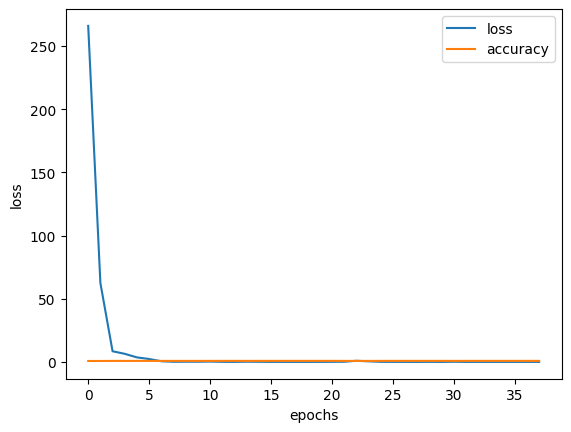

In [44]:
plt.figure(figsize = (16, 9))
pd.DataFrame(model1_history.history).plot()
plt.ylabel('loss')
plt.xlabel('epochs')

In [45]:
model1.evaluate(ibaraki_X, ibaraki_y)

23/23 [==============================] - 0s 4ms/step - loss: 0.0271 - accuracy: 0.9986 - f1_score: 0.9993


[0.02713586390018463, 0.9986282587051392, array([0.99931365], dtype=float32)]

In [60]:
# Tokyo similarity to CNN
check_pred_similarity2(X_test, model1.predict(X_test), feature_df[feature_df['prefecture'] == 'tokyo'])

7/7 [==============================] - 0s 3ms/step
193
y_pred [0.9962458]
feature 5
0 0
y_pred [0.9995011]
feature 4
0 0
y_pred [0.9607171]
feature 2
0 0
y_pred [0.966108]
feature 6
0 0
y_pred [0.9993519]
feature 8


KeyboardInterrupt: 

## Model 2: RandomForestClassifier

In [ ]:
model2 = RandomForestClassifier(n_estimators=100, random_state=0)
model2_history = model2.fit(X_train, y_train.ravel())

model2_y_pred = model2.predict(X_test)

In [ ]:
model2_accuracy = accuracy_score(y_test.ravel(), model2_y_pred)
model2_f1_score = f1_score(y_test.ravel(), model2_y_pred)
print('accuracy:', model2_accuracy, '- f1 score:', model2_f1_score)

accuracy: 0.9556620730976633 - f1 score: 0.9773145309625997


In [ ]:
model2_pred = model2.predict(ibaraki_X)
model2_accuracy = accuracy_score(ibaraki_y, model2_pred)
model2_f1_score = f1_score(ibaraki_y, model2_pred)
print('accuracy:', model2_accuracy, '- f1 score:', model2_f1_score)

accuracy: 0.9986282578875172 - f1 score: 0.9993136582017845


In [ ]:
# Tokyo
check_pred_similarity2(X_test, model2_y_pred, feature_df[feature_df[feature_df['prefecture'] == 'tokyo']])

In [ ]:
# Ibaraki
check_pred_similarity2(ibaraki_X, model2_pred, feature_df[feature_df[feature_df['prefecture'] == 'ibaraki']])

## Model 3: XGBoost

In [ ]:
model3 = xgb.XGBClassifier()
model3_history = model3.fit(X_train, y_train.ravel())

model3_y_pred = model3.predict(X_test)

In [ ]:
model3_accuracy = accuracy_score(y_test.ravel(), model3_y_pred)
model3_f1_score = f1_score(y_test.ravel(), model3_y_pred)
print('accuracy:', model3_accuracy, '- f1 score:', model3_f1_score)

accuracy: 0.957459556620731 - f1 score: 0.9782542113323124


### Model 3b: Another implementation of XGBoost

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,
    'seed': 42
}

# Specify the number of boosting rounds
num_rounds = 100

In [ ]:
evals_result = {}
model3b = xgb.train(params, dtrain, num_rounds, evals=[(dtrain, 'train'), (dtest, 'test')], evals_result=evals_result, verbose_eval=True)

[0]	train-logloss:0.19548	test-logloss:0.21272
[1]	train-logloss:0.18775	test-logloss:0.20589
[2]	train-logloss:0.18111	test-logloss:0.20013
[3]	train-logloss:0.17527	test-logloss:0.19525
[4]	train-logloss:0.16996	test-logloss:0.19096
[5]	train-logloss:0.16543	test-logloss:0.18715
[6]	train-logloss:0.16132	test-logloss:0.18381
[7]	train-logloss:0.15776	test-logloss:0.18110
[8]	train-logloss:0.15480	test-logloss:0.17894
[9]	train-logloss:0.15218	test-logloss:0.17711
[10]	train-logloss:0.14970	test-logloss:0.17528
[11]	train-logloss:0.14767	test-logloss:0.17394
[12]	train-logloss:0.14590	test-logloss:0.17274
[13]	train-logloss:0.14422	test-logloss:0.17156
[14]	train-logloss:0.14277	test-logloss:0.17100
[15]	train-logloss:0.14140	test-logloss:0.17041
[16]	train-logloss:0.14017	test-logloss:0.17010
[17]	train-logloss:0.13910	test-logloss:0.16943
[18]	train-logloss:0.13798	test-logloss:0.16882
[19]	train-logloss:0.13710	test-logloss:0.16870
[20]	train-logloss:0.13636	test-logloss:0.16860
[2

In [ ]:
train_logloss = evals_result['train']['logloss']
test_logloss = evals_result['test']['logloss']

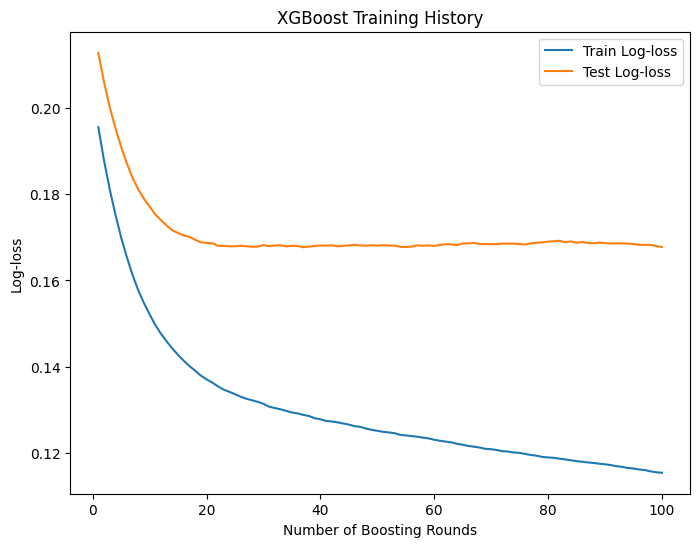

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, num_rounds + 1), train_logloss, label='Train Log-loss')
plt.plot(np.arange(1, num_rounds + 1), test_logloss, label='Test Log-loss')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Log-loss')
plt.title('XGBoost Training History')
plt.legend()
plt.show()

In [ ]:
y_pred = model3b.predict(dtest)
y_pred_binary = (y_pred > 0.5).astype(int)

model3b_accuracy = accuracy_score(y_test, y_pred_binary)
model3b_f1 = f1_score(y_test, y_pred_binary)

In [ ]:
print('accuracy:', model3b_accuracy, '- f1 score:', model3b_f1)

accuracy: 0.9580587177950869 - f1 score: 0.9785801713586291


In [ ]:
# Tokyo
check_pred_similarity2(X_test, y_pred, feature_df[feature_df[feature_df['prefecture'] == 'tokyo']])

In [ ]:
dtest = xgb.DMatrix(ibaraki_X)

y_pred = model3b.predict(dtest)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(ibaraki_y, y_pred_binary)
f1 = f1_score(ibaraki_y, y_pred_binary)

print('accuracy:', accuracy, '- f1 score:', f1)

accuracy: 0.9986282578875172 - f1 score: 0.9993136582017845


In [ ]:
# Ibaraki
check_pred_similarity2(ibaraki_X, y_pred, feature_df[feature_df[feature_df['prefecture'] == 'ibaraki']])

## Model 4: (Node-level) Rudimentary GCN

Semi-Supervised Classification with Graph Convolutional Networks (https://arxiv.org/abs/1609.02907) by *Thomas N. Kipf, Max Welling*

This takes the adjacency matrix created earlier and trains binary classification on the 19 features of X.

In [ ]:
learning_rate = 1e-2
seed = 0
epochs = 200
patience = 10

tf.random.set_seed(seed=seed)

In [ ]:
X.shape, a.shape, y.shape

((8343, 26), (8343, 8343), (8343, 1))

In [ ]:
class MyDataset(Dataset):
  def __init__(self, x, adj, y, **kwargs):
    self.x = x
    self.adj = adj
    self.y = y
    super().__init__(**kwargs)

  def read(self):
    return [Graph(x=self.x, a=self.adj, y=self.y)]

In [ ]:
adj = a

In [ ]:
dataset = MyDataset(X, adj, y) # The GCNConv layer preprocessing makes it worse

In [ ]:
idxs = np.random.permutation(len(X))

split_va, split_te = int(0.8 * len(X)), int(0.9 * len(X))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])

mask_tr = np.zeros(len(X), dtype=bool)
mask_va = np.zeros(len(X), dtype=bool)
mask_te = np.zeros(len(X), dtype=bool)
mask_tr[idx_tr] = True
mask_va[idx_va] = True
mask_te[idx_te] = True

In [ ]:
np.sum(mask_tr), np.sum(mask_va), np.sum(mask_te)

(6674, 834, 835)

In [ ]:
# We convert the binary masks to sample weights so that we can compute the
# average loss over the nodes (following original implementation by
# Kipf & Welling)
def mask_to_weights(mask):
    return mask.astype(np.float32) / np.count_nonzero(mask)

In [ ]:
weights_tr, weights_va, weights_te = (
    mask_to_weights(mask)
    for mask in (mask_tr, mask_va, mask_te)
)

In [ ]:
model4 = GCN(n_labels=dataset.n_labels)
model4.compile(
    optimizer=Adam(learning_rate),
    loss=BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.F1Score(threshold=0.5)],
    weighted_metrics=['acc'], # F1 score doesn't work if implemented normally
)

In [ ]:
loader_tr = SingleLoader(dataset, sample_weights=weights_tr)
loader_va = SingleLoader(dataset, sample_weights=weights_va)
model4_history = model4.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
)

Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 0.6752 - accuracy: 0.9657 - f1_score: 0.9826 - acc: 0.9655 - val_loss: 0.6198 - val_accuracy: 0.9657 - val_f1_score: 0.9826 - val_acc: 0.9592
Epoch 2/200
1/1 [==============================] - 0s 37ms/step - loss: 0.5228 - accuracy: 0.9657 - f1_score: 0.9826 - acc: 0.9655 - val_loss: 0.4724 - val_accuracy: 0.9657 - val_f1_score: 0.9826 - val_acc: 0.9592
Epoch 3/200
1/1 [==============================] - 0s 52ms/step - loss: 0.4795 - accuracy: 0.9657 - f1_score: 0.9826 - acc: 0.9655 - val_loss: 0.4022 - val_accuracy: 0.9657 - val_f1_score: 0.9826 - val_acc: 0.9592
Epoch 4/200
1/1 [==============================] - 0s 48ms/step - loss: 0.5042 - accuracy: 0.9657 - f1_score: 0.9826 - acc: 0.9655 - val_loss: 0.3857 - val_accuracy: 0.9657 - val_f1_score: 0.9826 - val_acc: 0.9592
Epoch 5/200
1/1 [==============================] - 0s 32ms/step - loss: 0.4876 - accuracy: 0.9657 - f1_score: 0.9826 - acc: 0.9655 - val_loss: 0.4

In [ ]:
loader_te = SingleLoader(dataset, sample_weights=weights_te)
eval_results = model4.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print('loss: {} - accuracy: {}'.format(*eval_results))

1/1 [==============================] - 0s 34ms/step - loss: 0.0015 - accuracy: 0.9657 - f1_score: 0.9826 - acc: 0.9737
loss: 0.0015214557060971856 - accuracy: 0.9657197594642639


Text(0.5, 0, 'epochs')

<Figure size 1600x900 with 0 Axes>

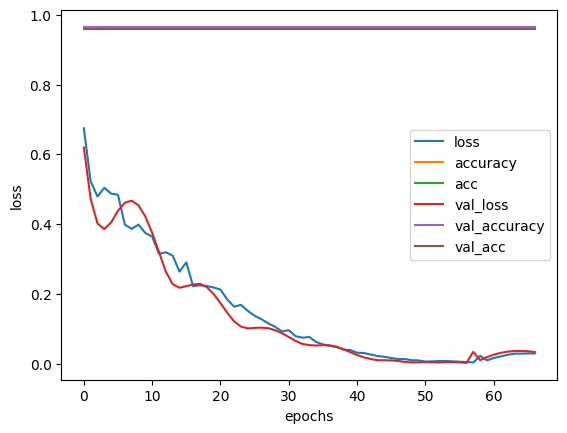

In [ ]:
plt.figure(figsize = (16, 9))
pd.DataFrame(model4_history.history).plot()
plt.ylabel('loss')
plt.xlabel('epochs')

In [ ]:
model4.summary()

Model: "gcn_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_25 (Dropout)        multiple                  0         
                                                                 
 gcn_conv_13 (GCNConv)       multiple                  416       
                                                                 
 dropout_26 (Dropout)        multiple                  0         
                                                                 
 gcn_conv_14 (GCNConv)       multiple                  16        
                                                                 
Total params: 432 (1.69 KB)
Trainable params: 432 (1.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Tokyo
check_pred_similarity2(loader_tr.load(), model4.predict(loader_tr.load()), feature_df[feature_df[feature_df['prefecture'] == 'tokyo']])

## Model 5: (Node-level) ChebConv

Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering (https://arxiv.org/abs/1606.09375) by
*Michaël Defferrard, Xavier Bresson, Pierre Vandergheynst*

In [ ]:
channels = 16  # Number of channels in the first layer
K = 2  # Max degree of the Chebyshev polynomials
dropout = 0.5  # Dropout rate for the features
l2_reg = 2.5e-4  # L2 regularization rate
learning_rate = 1e-2  # Learning rate
epochs = 200  # Number of training epochs
patience = 10  # Patience for early stopping
a_dtype = dataset[0].a.dtype  # Only needed for TF 2.1

N = dataset.n_nodes  # Number of nodes in the graph
F = dataset.n_node_features  # Original size of node features
n_out = dataset.n_labels  # Number of classes

In [ ]:
# Model definition
x_in = Input(shape=(F,))
a_in = Input((N,), sparse=True, dtype=a_dtype)

do_1 = Dropout(dropout)(x_in)
gc_1 = ChebConv(
    channels, K=K, activation="relu", kernel_regularizer=l2(l2_reg), use_bias=False
)([do_1, a_in])
do_2 = Dropout(dropout)(gc_1)
gc_2 = ChebConv(n_out, K=K, activation="softmax", use_bias=False)([do_2, a_in])

In [ ]:
model5 = Model(inputs=[x_in, a_in], outputs=gc_2)
optimizer = Adam(learning_rate=learning_rate)
model5.compile(
    optimizer=optimizer,
    loss=BinaryCrossentropy(reduction="sum"),  # To compute mean
    weighted_metrics=["acc"],
)
model5.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 26)]                 0         []                            
                                                                                                  
 dropout_27 (Dropout)        (None, 26)                   0         ['input_25[0][0]']            
                                                                                                  
 input_26 (InputLayer)       [(None, 8343)]               0         []                            
                                                                                                  
 cheb_conv_6 (ChebConv)      (None, 16)                   832       ['dropout_27[0][0]',          
                                                                     'input_26[0][0]']     

In [ ]:
# Train model
loader_tr = SingleLoader(dataset, sample_weights=weights_tr)
loader_va = SingleLoader(dataset, sample_weights=weights_va)
model5.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
)

Epoch 1/200
1/1 [==============================] - 1s 829ms/step - loss: 8660.0732 - acc: 0.9655 - val_loss: 651.3709 - val_acc: 0.9592
Epoch 2/200
1/1 [==============================] - 0s 30ms/step - loss: 3938.2151 - acc: 0.9655 - val_loss: 1262.1681 - val_acc: 0.9592
Epoch 3/200
1/1 [==============================] - 0s 31ms/step - loss: 2170.9197 - acc: 0.9655 - val_loss: 1786.6620 - val_acc: 0.9592
Epoch 4/200
1/1 [==============================] - 0s 30ms/step - loss: 1733.5369 - acc: 0.9655 - val_loss: 2255.5789 - val_acc: 0.9592
Epoch 5/200
1/1 [==============================] - 0s 31ms/step - loss: 2141.4390 - acc: 0.9655 - val_loss: 2590.0811 - val_acc: 0.9592
Epoch 6/200
1/1 [==============================] - 0s 31ms/step - loss: 2379.3667 - acc: 0.9655 - val_loss: 2793.5010 - val_acc: 0.9592
Epoch 7/200
1/1 [==============================] - 0s 30ms/step - loss: 2298.7329 - acc: 0.9655 - val_loss: 2919.7935 - val_acc: 0.9592
Epoch 8/200
1/1 [==============================]

In [ ]:
loader_te = SingleLoader(dataset, sample_weights=weights_te)
eval_results = model5.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print('loss: {} - accuracy: {}'.format(*eval_results))

1/1 [==============================] - 0s 15ms/step - loss: 378.5757 - acc: 0.9737
loss: 378.57574462890625 - accuracy: 0.973652720451355


## Model 6: (Node-level) GAT

Graph Attention Networks (https://arxiv.org/abs/1710.10903) by
*Petar Veličković, Guillem Cucurull, Arantxa Casanova, Adriana Romero, Pietro Liò, Yoshua Bengio*

In [ ]:
dataset_gat = MyDataset(X, adj, y, transforms=[LayerPreprocess(GATConv)])

In [ ]:
# Parameters
channels = 8  # Number of channels in each head of the first GAT layer
n_attn_heads = 8  # Number of attention heads in first GAT layer
dropout = 0.6  # Dropout rate for the features and adjacency matrix
l2_reg = 2.5e-4  # L2 regularization rate
learning_rate = 5e-3  # Learning rate
epochs = 20000  # Number of training epochs
patience = 100  # Patience for early stopping

N = dataset.n_nodes  # Number of nodes in the graph
F = dataset.n_node_features  # Original size of node features
n_out = dataset.n_labels  # Number of classes

In [ ]:
# Model definition
x_in = Input(shape=(F,))
a_in = Input((N,), sparse=True)

do_1 = Dropout(dropout)(x_in)
gc_1 = GATConv(
    channels,
    attn_heads=n_attn_heads,
    concat_heads=True,
    dropout_rate=dropout,
    activation="elu",
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
)([do_1, a_in])
do_2 = Dropout(dropout)(gc_1)
gc_2 = GATConv(
    n_out,
    attn_heads=1,
    concat_heads=False,
    dropout_rate=dropout,
    activation="softmax",
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
)([do_2, a_in])

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# Build model
model6 = Model(inputs=[x_in, a_in], outputs=gc_2)
optimizer = Adam(learning_rate=learning_rate)
model6.compile(
    optimizer=optimizer,
    loss=BinaryCrossentropy(reduction="sum"),
    weighted_metrics=["acc"],
)
model6.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 26)]                 0         []                            
                                                                                                  
 dropout_29 (Dropout)        (None, 26)                   0         ['input_27[0][0]']            
                                                                                                  
 input_28 (InputLayer)       [(None, 8343)]               0         []                            
                                                                                                  
 gat_conv_6 (GATConv)        (None, 64)                   1856      ['dropout_29[0][0]',          
                                                                     'input_28[0][0]']     

In [ ]:
# Train model
loader_tr = SingleLoader(dataset_gat, sample_weights=weights_tr)
loader_va = SingleLoader(dataset_gat, sample_weights=weights_va)
model6.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
)

Epoch 1/20000
1/1 [==============================] - 3s 3s/step - loss: 92.9861 - acc: 0.9655 - val_loss: 680.6462 - val_acc: 0.9592
Epoch 2/20000
1/1 [==============================] - 0s 250ms/step - loss: 73.9607 - acc: 0.9655 - val_loss: 640.5560 - val_acc: 0.9592
Epoch 3/20000
1/1 [==============================] - 0s 217ms/step - loss: 91.8463 - acc: 0.9655 - val_loss: 600.0738 - val_acc: 0.9592
Epoch 4/20000
1/1 [==============================] - 0s 237ms/step - loss: 79.2788 - acc: 0.9655 - val_loss: 583.3663 - val_acc: 0.9592
Epoch 5/20000
1/1 [==============================] - 0s 218ms/step - loss: 50.1951 - acc: 0.9655 - val_loss: 568.8392 - val_acc: 0.9592
Epoch 6/20000
1/1 [==============================] - 0s 211ms/step - loss: 50.9968 - acc: 0.9655 - val_loss: 575.0709 - val_acc: 0.9592
Epoch 7/20000
1/1 [==============================] - 0s 214ms/step - loss: 52.3140 - acc: 0.9655 - val_loss: 575.8128 - val_acc: 0.9592
Epoch 8/20000
1/1 [==============================] 

In [ ]:
loader_te = SingleLoader(dataset_gat, sample_weights=weights_te)
eval_results = model6.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print('loss: {} - accuracy: {}'.format(*eval_results))

1/1 [==============================] - 0s 58ms/step - loss: 187.5427 - acc: 0.9737
loss: 187.54270935058594 - accuracy: 0.973652720451355


## Model 7: (Node-level) ARMAConv
Graph Neural Networks with convolutional ARMA filters (https://arxiv.org/abs/1901.01343)
by *Filippo Maria Bianchi, Daniele Grattarola, Cesare Alippi, Lorenzo Livi*

In [ ]:
channels = 16  # Number of channels in the first layer
iterations = 1  # Number of iterations to approximate each ARMA(1)
order = 2  # Order of the ARMA filter (number of parallel stacks)
share_weights = True  # Share weights in each ARMA stack
dropout_skip = 0.75  # Dropout rate for the internal skip connection of ARMA
dropout = 0.5  # Dropout rate for the features
l2_reg = 5e-5  # L2 regularization rate
learning_rate = 1e-2  # Learning rate
epochs = 20000  # Number of training epochs
patience = 100  # Patience for early stopping
a_dtype = dataset[0].a.dtype  # Only needed for TF 2.1

N = dataset.n_nodes  # Number of nodes in the graph
F = dataset.n_node_features  # Original size of node features
n_out = dataset.n_labels  # Number of classes

In [ ]:
x_in = Input(shape=(F,))
a_in = Input((N,), sparse=True, dtype=a_dtype)

gc_1 = ARMAConv(
    channels,
    iterations=iterations,
    order=order,
    share_weights=share_weights,
    dropout_rate=dropout_skip,
    activation="elu",
    gcn_activation="elu",
    kernel_regularizer=l2(l2_reg),
)([x_in, a_in])
gc_2 = Dropout(dropout)(gc_1)
gc_2 = ARMAConv(
    n_out,
    iterations=1,
    order=1,
    share_weights=share_weights,
    dropout_rate=dropout_skip,
    activation="softmax",
    gcn_activation=None,
    kernel_regularizer=l2(l2_reg),
)([gc_2, a_in])

In [ ]:
model7 = Model(inputs=[x_in, a_in], outputs=gc_2)
optimizer = Adam(learning_rate=learning_rate)
model7.compile(
    optimizer=optimizer, loss="binary_crossentropy", weighted_metrics=["acc"]
)
model7.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_29 (InputLayer)       [(None, 26)]                 0         []                            
                                                                                                  
 input_30 (InputLayer)       [(None, 8343)]               0         []                            
                                                                                                  
 arma_conv_6 (ARMAConv)      (None, 16)                   1696      ['input_29[0][0]',            
                                                                     'input_30[0][0]']            
                                                                                                  
 dropout_31 (Dropout)        (None, 16)                   0         ['arma_conv_6[0][0]']  

In [ ]:
loader_tr = SingleLoader(dataset, sample_weights=mask_tr)
loader_va = SingleLoader(dataset, sample_weights=mask_va)
model7.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
)

Epoch 1/20000
1/1 [==============================] - 2s 2s/step - loss: 123012.4688 - acc: 0.9655 - val_loss: 11671.4502 - val_acc: 0.9592
Epoch 2/20000
1/1 [==============================] - 0s 47ms/step - loss: 98090.7422 - acc: 0.9655 - val_loss: 8311.1729 - val_acc: 0.9592
Epoch 3/20000
1/1 [==============================] - 0s 43ms/step - loss: 73365.7656 - acc: 0.9655 - val_loss: 4616.4258 - val_acc: 0.9592
Epoch 4/20000
1/1 [==============================] - 0s 46ms/step - loss: 45030.4102 - acc: 0.9655 - val_loss: 736.9822 - val_acc: 0.9592
Epoch 5/20000
1/1 [==============================] - 0s 47ms/step - loss: 29609.9082 - acc: 0.9655 - val_loss: 157.6904 - val_acc: 0.9592
Epoch 6/20000
1/1 [==============================] - 0s 44ms/step - loss: 15767.1729 - acc: 0.9655 - val_loss: 331.6265 - val_acc: 0.9592
Epoch 7/20000
1/1 [==============================] - 0s 43ms/step - loss: 7729.8330 - acc: 0.9655 - val_loss: 495.8902 - val_acc: 0.9592
Epoch 8/20000
1/1 [=============

In [ ]:
loader_te = SingleLoader(dataset, sample_weights=weights_te)
eval_results = model7.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print('loss: {} - accuracy: {}'.format(*eval_results))

1/1 [==============================] - 17s 17s/step - loss: 0.1122 - acc: 0.9737
loss: 0.11220461875200272 - accuracy: 0.973652720451355


## Model 8: Simple GCN
Simplifying Graph Convolutional Networks (https://arxiv.org/abs/1902.07153) by
*Felix Wu, Tianyi Zhang, Amauri Holanda de Souza Jr., Christopher Fifty, Tao Yu, Kilian Q. Weinberger*

In [ ]:
class SGCN:
  def __init__(self, K):
    self.K = K

  def __call__(self, graph):
    out = csr_matrix(graph.a) # Convert ndarray to csr_matrix
    for _ in range(self.K - 1):
        out = out.dot(out)
    out.sort_indices()
    graph.a = out
    return graph

In [ ]:
K = 2  # Propagation steps for SGCN
dataset_sgcn = MyDataset(X, adj, y, transforms=[LayerPreprocess(GCNConv), SGCN(K)])

In [ ]:
l2_reg = 5e-6  # L2 regularization rate
learning_rate = 0.2  # Learning rate
epochs = 20000  # Number of training epochs
patience = 200  # Patience for early stopping
a_dtype = dataset_sgcn[0].a.dtype  # Only needed for TF 2.1

N = dataset_sgcn.n_nodes  # Number of nodes in the graph
F = dataset_sgcn.n_node_features  # Original size of node features
n_out = dataset_sgcn.n_labels  # Number of classes

In [ ]:
x_in = Input(shape=(F,))
a_in = Input((N,), sparse=True, dtype=a_dtype)

output = GCNConv(
    n_out, activation="softmax", kernel_regularizer=l2(l2_reg), use_bias=False
)([x_in, a_in])

In [ ]:
model8 = Model(inputs=[x_in, a_in], outputs=output)
optimizer = Adam(learning_rate=learning_rate)
model8.compile(
    optimizer=optimizer, loss="binary_crossentropy", weighted_metrics=["acc"]
)
model8.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 26)]                 0         []                            
                                                                                                  
 input_32 (InputLayer)       [(None, 8343)]               0         []                            
                                                                                                  
 gcn_conv_15 (GCNConv)       (None, 1)                    26        ['input_31[0][0]',            
                                                                     'input_32[0][0]']            
                                                                                                  
Total params: 26 (104.00 Byte)
Trainable params: 26 (104.00 Byte)
Non-trainable params: 0 (

In [ ]:
loader_tr = SingleLoader(dataset_sgcn, sample_weights=mask_tr)
loader_va = SingleLoader(dataset_sgcn, sample_weights=mask_va)
model8.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=patience, restore_best_weights=True)],
)

Epoch 1/20000
1/1 [==============================] - 1s 788ms/step - loss: 1681.8060 - acc: 0.9655 - val_loss: 8.9772 - val_acc: 0.9592
Epoch 2/20000
1/1 [==============================] - 0s 32ms/step - loss: 60.2176 - acc: 0.9655 - val_loss: 20.6791 - val_acc: 0.9592
Epoch 3/20000
1/1 [==============================] - 0s 35ms/step - loss: 136.6319 - acc: 0.9655 - val_loss: 29.3059 - val_acc: 0.9592
Epoch 4/20000
1/1 [==============================] - 0s 31ms/step - loss: 192.9631 - acc: 0.9655 - val_loss: 35.9921 - val_acc: 0.9592
Epoch 5/20000
1/1 [==============================] - 0s 46ms/step - loss: 236.6207 - acc: 0.9655 - val_loss: 41.2871 - val_acc: 0.9592
Epoch 6/20000
1/1 [==============================] - 0s 33ms/step - loss: 271.1929 - acc: 0.9655 - val_loss: 45.5104 - val_acc: 0.9592
Epoch 7/20000
1/1 [==============================] - 0s 31ms/step - loss: 298.7649 - acc: 0.9655 - val_loss: 48.8688 - val_acc: 0.9592
Epoch 8/20000
1/1 [==============================] - 0s

In [ ]:
loader_te = SingleLoader(dataset_sgcn, sample_weights=weights_te)
eval_results = model8.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print('loss: {} - accuracy: {}'.format(*eval_results))

1/1 [==============================] - 0s 129ms/step - loss: 6.6447e-04 - acc: 0.9737
loss: 0.0006644686218351126 - accuracy: 0.973652720451355


## Preprocessing Graph Level Data

In [ ]:
earthquake_list = read_pickle('tokyo/earthquake_list')
earthquake_list

ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

In [ ]:
X.shape, adj.shape, y.shape

In [ ]:
def haversine_distance(coords1, coords2):
    lat1, lon1 = np.radians(coords1)
    lat2, lon2 = np.radians(coords2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371.0 * c  # Radius of the Earth in kilometers
    return km

In [ ]:
print(np.array([feature_df['shelter_count'] > 0]).astype(np.float32))

In [ ]:
class MultiGraphDataset(Dataset):
  def __init__(self, features, earthquake_list, **kwargs):
    self.n_samples = len(features)
    self.features_df = features # pass in only features, X_df
    self.earthquake_df = earthquake_list
    super().__init__(**kwargs)

  def read(self):
    row_indices, col_indices = np.indices((self.n_samples, self.n_samples))
    mat = (row_indices ^ col_indices) == 1
    adj = mat.astype(np.int32)

    def make_graph(i, row):
      # graph.add_node('center') #, **self.feature_df.to_dict()
      node_attributes = []

      for index, node in self.earthquake_df.iterrows():
        distance = haversine_distance((row['latitude'], row['latitude']), (node['latitude'], node['latitude']))
        node_attributes.append([distance, node['depth'], node['magnitude']])

        # graph.add_node(index, distance=distance, depth=node['depth'], magnitude=node['magnitude'])
        # graph.add_edge('center', index)

      x = np.array(node_attributes, dtype=np.float32) # Since center has no attributes, the shape is (998, 3)
      # adj = csr_matrix(nx.adjacency_matrix(graph))
      y = np.array([row['shelter_count'] > 0]).astype(np.float32)

      print(x, adj.todense(), y)
      print(i, x.shape, adj.shape, y.shape)

    return [make_graph(i + 1, row) for i, row in self.features_df.iterrows()]

In [ ]:
multigraph_dataset = MultiGraphDataset(feature_df, earthquake_list)

In [ ]:
batch_size = 32
learning_rate = 0.01
epochs = 400

In [ ]:
np.random.shuffle(multigraph_dataset)
split = int(0.8 * len(multigraph_dataset))
multigraph_dataset_tr, multigraph_dataset_te = multigraph_dataset[:split], multigraph_dataset[split:]

# multigraph_dataset loaders
loader_tr = DisjointLoader(multigraph_dataset_tr, batch_size=batch_size, epochs=epochs)
loader_te = DisjointLoader(multigraph_dataset_te, batch_size=batch_size)

In [ ]:
model = GeneralGNN(data.n_labels, activation="softmax")
optimizer = Adam(learning_rate)
loss_fn = BinaryCrossentropy()

In [ ]:
# prompt: Ideas for graph theory based regression (using some sort of neural network)

# 1. Graph Convolutional Network (GCN) for regression:
# This model uses a GCN to learn the relationships between nodes in a graph and predict a continuous value for each node.

class GCNRegressor(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCNRegressor, self).__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# 2. Graph Attention Network (GAT) for regression:
# This model uses a GAT to learn the relationships between nodes in a graph and predict a continuous value for each node.

class GATRegressor(nn.Module):
    def __init__(self, num_features, num_classes, heads):
        super(GATRegressor, self).__init__()
        self.conv1 = GATConv(num_features, 64, heads, dropout=0.6)
        self.conv2 = GATConv(64 * heads, num_classes, 1, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# 3. Edge Convolutional Network (ECN) for regression:
# This model uses an ECN to learn the relationships between edges in a graph and predict a continuous value for each edge.

class ECNRegressor(nn.Module):
    def __init__(self, num_features, num_classes):
        super(ECNRegressor, self).__init__()
        self.conv1 = ECCConv(num_features, 64)
        self.conv2 = ECCConv(64, num_classes)

    def forward(self, x, edge_index, edge_attr):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.conv2(x, edge_index, edge_attr)
        return x
